In [3]:
import sqlite3

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

import alpha_hull

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Lecture des zones parents :

db_filename = '../data/arbres.db'
db = sqlite3.connect(db_filename)

cursor = db.cursor()

In [6]:
cursor.execute(""" SELECT DISTINCT code_parent, code_parent_desc FROM arbres  """)
zones_parent = { x[0]: {'name':x[1]} for x in cursor.fetchall()}

print( len(zones_parent) )

1445


In [7]:
list(zones_parent.keys())[0]

'ESP810'

In [272]:
for code_parent, infos in zones_parent.items():
    cursor.execute("""
        SELECT genre_bota, longitude, latitude FROM arbres 
        WHERE code_parent  = ?""", (code_parent, ))

    #nametuples = cursor.fetchmany(10)
    infos['arbres'] = cursor.fetchall()

In [366]:
R_Earth =  6371008  # m , volumétrique ?
def value_in_degree( meter ):
    return meter/R_Earth *180/np.pi

def value_in_meter( deg ):
    return deg*np.pi/180 * R_Earth

R_Earth =  6371008  # m , volumétrique ?
def convert_to_meter( array ):
    uv = array*np.pi/180*R_Earth
    uv = uv - uv.mean( axis=0 )
    return uv

def convert_to_degree( array, offset ):
    uv = array / R_Earth * 180/np.pi
    uv = uv + offset
    return uv

In [457]:
def get_coords_array( arbres ):
    XY = [ (tree[1], tree[2])  for tree in arbres ]
    XY = np.array( XY )
    return convert_to_meter( XY ), XY.mean( axis=0 )

def get_coords_deg( arbres ):
    latlon = [ (tree[1], tree[2])  for tree in arbres ]
    return np.array( latlon )
    

def get_species( arbres ):
    spec = { tree[0] for tree in arbres }
    return list(spec)

In [458]:
# Pick one :
code_parent, infos = list( zones_parent.items() )[17]
print( infos['name'], len(infos['arbres']), get_species(infos['arbres'])  )

Cité Chatelet Wash Poincare 63 ['Prunus', 'Magnolia', 'Tilia', 'Carpinus', 'Koelreuteria', 'Pinus', 'Platanus']


In [445]:
def get_coordsarray( infos ):
    """ construit le ndarray des coordonnées en les convertissant (scale, pas de projection sphèrique)
        en mètre
        retourne l'array (n_points, n_dim), et la fonction de scaling inverse
    """
    points_deg = get_coords_deg( infos['arbres'] )
    center_deg = points_deg.mean( axis = 0 )

    R_Earth =  6371008  # m
    scale_factor = np.pi/180*R_Earth

    points_m = (points_deg - center_deg)*scale_factor
    scale_back = lambda X: X/scale_factor + center_deg
    
    return points_m, scale_back

In [446]:
points_m, scale_back = get_coordsarray( infos )

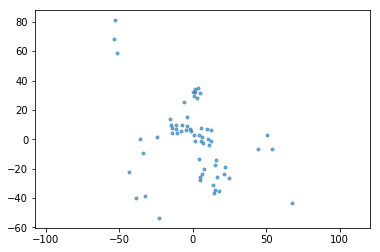

In [447]:
plt.plot( *points_m.T, '.', alpha=.6 )
plt.axis('equal');

In [449]:
def add_contourpoints( points_list,  n_points = 5, r_cercle = 3 ):
    """ Ajoute des points virtuels autour des arbres pour donner
        une épaisseur au polygone dans le cas où les arbres sont 
        tous alignés
        
        n_point: nombre de points à ajouter
        r_cercle: distance au centre 
    """

    thetas = np.linspace( 0, 2*np.pi, n_points+1 )[:-1]

    added_point = []
    for x, y in points_list:

        x_add = x + r_cercle * np.cos( thetas )
        y_add = y + r_cercle * np.sin( thetas )

        added_point.extend( zip( x_add, y_add ) )
    
    return np.array( added_point )

In [450]:
added_point = add_contourpoints( points_m )

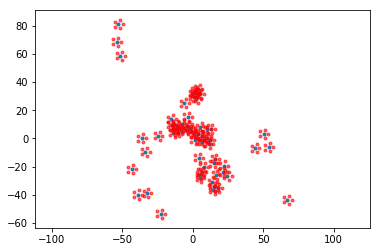

In [451]:
plt.plot( *points_m.T, '.' )
plt.axis('equal');

plt.plot( *added_point.T, '.r', alpha=.6 )
plt.axis('equal');

In [452]:
# - Alpha hub - 
all_points = np.concatenate( (added_point, points_list) )

Rcritic = 12  # m
polygon = alpha_hull.alpha_shape( all_points, Rcritic  )[0]

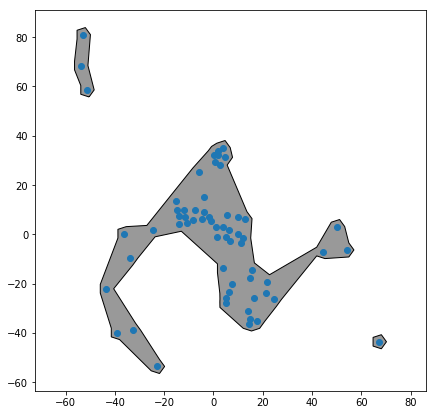

In [453]:
# plot
alpha_hull.plot_polygon( polygon  )
plt.plot( *points_list.T, 'o' )
plt.axis('equal');

In [399]:
# Rq: Delaunay ne marche pas avec les coords en degrée dec. ... 

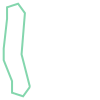

In [431]:
polygon.boundary[1]

In [406]:
import geojson as gj
# https://pypi.python.org/pypi/geojson#polygon

In [442]:
def get_geom( polygon, scale_back ):
    """ retourne la partie Geométrie du GeoJson pour l'objet polygon
        peut être un simple ou MultiPolygon
        - convertie les coords en degrée décimaux avec la fonction scale_back
    """
    
    if polygon.geom_type == 'MultiPolygon':
        
        all_coords = []
        for part in polygon.boundary:
            boundary_coords = part.coords
            boundary_coords = scale_back( np.array(boundary_coords) ).tolist()
            all_coords.append( (boundary_coords, )  ) # supplementary tuple ??

        geom = gj.MultiPolygon( all_coords )

    elif polygon.geom_type == 'Polygon':
        boundary_coords = polygon.boundary.coords
        boundary_coords = scale_back( np.array(boundary_coords) ).tolist()
        geom = gj.Polygon( boundary_coords )
        
    return geom

In [443]:
geom = get_geom( polygon, scale_back )
featprops = {'code_parent':code_parent , 'code_parent_desc':infos['name'], 'genre':}
feat = gj.Feature(geometry=geom, properties={"code_parent": "Spain"}) 

In [455]:
def get_coordsarray( infos ):
    """ construit le ndarray des coordonnées en les convertissant (scale, pas de projection sphèrique)
        en mètre
        retourne l'array (n_points, n_dim), et la fonction de scaling inverse
    """
    points_deg = get_coords_deg( infos['arbres'] )
    center_deg = points_deg.mean( axis = 0 )

    R_Earth =  6371008  # m
    scale_factor = np.pi/180*R_Earth

    points_m = (points_deg - center_deg)*scale_factor
    scale_back = lambda X: X/scale_factor + center_deg
    
    return points_m, scale_back

{'arbres': [('Pinus', 5.74770117144835, 45.1790066202352),
  ('Carpinus', 5.74749529529031, 45.1791023562271),
  ('Tilia', 5.74799856026338, 45.1789769489607),
  ('Carpinus', 5.74763422011432, 45.1793562741835),
  ('Carpinus', 5.74761528577425, 45.1793291925258),
  ('Platanus', 5.74754661575057, 45.1792654673466),
  ('Pinus', 5.74770907586361, 45.1790264164748),
  ('Pinus', 5.74749406888944, 45.179127057481),
  ('Platanus', 5.74727353179737, 45.179042127795),
  ('Magnolia', 5.74724934862358, 45.1786815470861),
  ('Carpinus', 5.74761293773373, 45.1790305581108),
  ('Carpinus', 5.74773356965711, 45.1788815875052),
  ('Platanus', 5.74763654612739, 45.178916310185),
  ('Pinus', 5.74772520197763, 45.1787605234148),
  ('Carpinus', 5.74771384907484, 45.1790969402073),
  ('Pinus', 5.74764706029374, 45.1790283781634),
  ('Carpinus', 5.74747413632408, 45.1791063083827),
  ('Carpinus', 5.74761516446974, 45.1793445049595),
  ('Platanus', 5.74711529485932, 45.1796554195346),
  ('Carpinus', 5.747465